In [2]:
import numpy as np
import scipy.stats as sp
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
%matplotlib inline


#### Problem 1

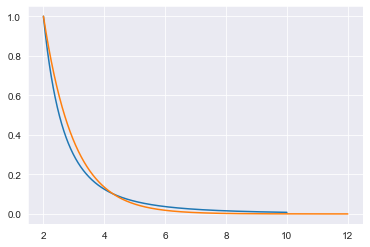

In [28]:
# plot the target density
x_plot = np.linspace(2,10,1000)
y_plot = 8/pow(x_plot,3)
sns.set_style('darkgrid')
ax_ = sns.lineplot(x=x_plot,y=y_plot)

# plot an exponential density shifted at 2
x_all = np.linspace(0,10,10000)
y_prop = sp.expon.pdf(x_all)
sns.lineplot(x=x_all+2,y=y_prop)

In [79]:
# function to do metropolis-hastings sampling
def metro_hast(f_pdf, g_pdf, g_gen,ndraws = 100,init_value = None, *args,**kwargs):
    ### function to run the general metropolis-hastings algorithm
    ### inputs
    ### f_pdf: a function that returns the pdf f(x)
    ### g_pdf: a function that returns the candidate value g(x_1|x_0)
    ### g_gen: a function that returns a random variable drawn from g(x_1|x_0)
    ### n_samples: the number of samples we want to generate from
    ### outputs
    ###----------------------------------------
    ###
    # following the text, initialize the initial samples
    # the first one is our initial
    sim_samples = g_gen(ndraws+1,*args,**kwargs)
    
    # allow for an initialization value 
    if init_value is not None:
        sim_samples[0]=init_value
        
    # we pull all the uniform variables we need upfront
    unif_rv = sp.uniform.rvs(size=ndraws)
    acceptance = np.zeros(ndraws)
    def accep_prob(x1,x0):
        if f_pdf(x0,x1) ==0:
            return 0.
        else:
            return f_pdf(x1,x0,*args,**kwargs)*g_pdf(x0,x1,*args,**kwargs)/(f_pdf(x0,x1,*args,**kwargs)*g_pdf(x1,x0,*args,**kwargs))

    for i_sim in range(1,len(sim_samples+1)):
        y = sim_samples[i_sim]
        x = sim_samples[i_sim-1]
        p_acc = min(1,accep_prob(y,x))
        sim_samples[i_sim] = x+(y-x)*(unif_rv[i_sim-1]<=p_acc)
        if unif_rv[i_sim-1]<=p_acc:
            acceptance[i_sim-1]=1
                
    results = {'samples':sim_samples,'accept_rate':acceptance.sum()/ndraws}
    return results

# getting the target and proposal densities
def f_target(x,*args,**kwargs):
    if x>2:
        return 8/pow(x,3)
    else:
        return 0

def g_exp_pdf(x,*args,**kwargs):
    # use an exponential distribution
    # because this distribution is iid the previous value has no bearing on the future
    # we subtract 2 since this is a shifted exponential
    return sp.expon.pdf(x-2)

def g_exp_gen(nobs,*args,**kwargs):
    # get shifted exponential values
    return sp.expon.rvs(size=nobs)+2

def g_logn_pdf(x,*args,**kwargs):
    return sp.lognorm.pdf(x,loc=2,s=1)

def g_logn_gen(nobs,*args,**kwargs):
    return sp.lognorm.rvs(loc=2,s=1,size=nobs)

In [80]:
test_logn = metro_hast(f_target,g_logn_pdf,g_logn_gen,ndraw=10000,)
test_exp = metro_hast(f_target,g_exp_pdf,g_exp_gen,ndraw=10000,)

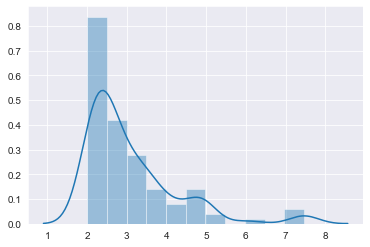

In [81]:
sns.distplot(test_exp['samples'])

#### Problem 3

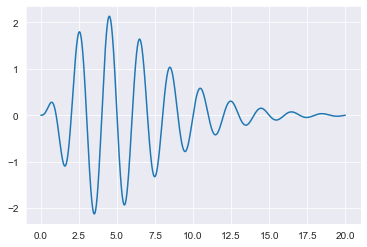

In [84]:
# first we plot the target integrand to see what it looks like
f_target = lambda x:pow(x,2)*np.sin(np.pi*x)*np.exp(-x/2)
x = np.linspace(0,20,10000)
sns.lineplot(x=x,y=f_target(x))

In [200]:
g_sample = sp.expon.rvs(size=100000,scale=3,)
g_func = lambda x: sp.expon.pdf(x,scale=3)

# calculating the integral
f_int_exp = np.mean(f_target(g_sample)/g_func(g_sample))
print(f_int_exp)

-0.10458080302010571


In [177]:
g_sample_norm = sp.lognorm.rvs(size=100000,s=10,loc=0)
g_norm_func = lambda x: sp.lognorm.pdf(x,s=10,loc=0)
f_int_lnorm = np.mean(f_target(g_sample_norm)/g_norm_func(g_sample_norm))
print(f_int_lnorm)


-0.07545883228005502


In [181]:
from scipy import integrate
f_int = integrate.quad(f_target, 0,np.inf,limit=100)
print(f_int[0])

-0.05529237717569376


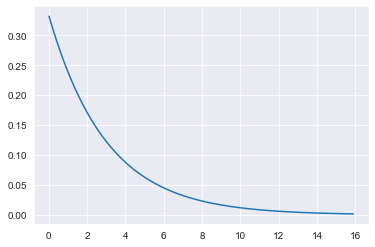

In [193]:
x = sp.expon.ppf(np.linspace(0.005,0.995,1000),scale=3)
y = sp.expon.pdf(x,scale=3)
sns.lineplot(x=x,y=y)